# Proyecto procesamiento de imagenes

In [3]:
import cv2
from pyzbar.pyzbar import decode
import matplotlib.pyplot as plt
import numpy as np
# Get file names in /png
import os
from IPython.display import clear_output

In [5]:
# Decode QR codes
def decode_qr(qr_image):
  decoded_objects = decode(qr_image)
  if not decoded_objects:
      return False, ""
  return True, decoded_objects[0].data.decode("utf-8")


def get_txt_content(file_name):
  with open(file_name, 'r') as file:
    content = file.read()
  return content

def checkQr(image, txt_file_path):
  content = get_txt_content(txt_file_path)

  ok, decoded = decode_qr(image)
  if ok:
    return decoded == content
  return False

In [32]:
class Pipeline:
    def __init__(self, steps):
        self.steps = steps

    def run(self, data, check_qr=False):
        for step in self.steps:
            data = step(data)
            if check_qr:
                ok, _ = decode_qr(data)
                if ok:
                    break
        return data
   


In [7]:
''' Grayscale '''
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


In [8]:
''' Thresholding '''

def threshold(threshold_value=128):
    def inner(image, threshold_value=threshold_value):
        _, thresholded_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
        return thresholded_image
    return inner

def otsu_threshold(image):
    _, thresholded_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresholded_image

def multiple_threshold(thresholds):
    def inner(image):
        for threshold_value in thresholds:
            _, transformed = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
            ok, _ = decode_qr(transformed)
            if ok:
                return transformed
        return image
    return inner

def histogram_based_threshold(image):
    # Calculate histogram
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])

    # Find the white peak in the histogram
    white_peak = np.argmax(hist[200:]) + 200  # Start looking from 200 to avoid noise

    # Define padding to avoid noise based on how are the rest # of the pixels distributed
    total = np.sum(hist)
    peak_count = hist[white_peak][0]
    ratio = peak_count / total

    if ratio > 0.6:
        threshold_value = int(white_peak * 0.95)
    elif ratio > 0.3:
        threshold_value = int(white_peak * 0.9)
    else:
        threshold_value = int(white_peak * 0.85)


    # Calculate the threshold value
    threshold_value = max(threshold_value, 0)

    # Instead of binary thresholding, divide the levels into two parts
    # The left part is going to be divided by 2
    thresholded_image = np.zeros_like(image)
    thresholded_image[image < threshold_value] = image[image < threshold_value] // 2
    thresholded_image[image >= threshold_value] = image[image >= threshold_value] * 2
    
    return thresholded_image


In [9]:

''' Image Filtering '''
# Blurring
def gaussian_blur(kernel_size=5):
    def inner(image, kernel_size=kernel_size):
        return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    return inner

def median_blur(kernel_size=5):
    def inner(image, kernel_size=kernel_size):
        return cv2.medianBlur(image, kernel_size)
    return inner

# Morphological operations
def opening(kernel):
    def inner(image, kernel=kernel):
        return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return inner

def squared_opening(kernel_size=5):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    return opening(kernel)

def closing(kernel):
    def inner(image, kernel=kernel):
        return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return inner

def clahe_enhancement(clip_limit=2.0, tile_grid_size=(8, 8)):
    def inner(image, clip_limit=clip_limit, tile_grid_size=tile_grid_size):
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        return clahe.apply(image)
    return inner

def equalization(image):
    return cv2.equalizeHist(image)

In [10]:
# arithmetic operations
def add(constant=50):
    def inner(image, constant=constant):
        # Ensure the constant is a numpy array of the same shape as the image
        return cv2.add(image, constant)
    return inner

def subtract(constant=50):
    def inner(image, constant=constant):
        # Ensure the constant is a numpy array of the same shape as the image
        return cv2.subtract(image, constant)
    return inner

def multiply(constant=1.5):
    def inner(image, constant=constant):
        # Ensure the constant is a numpy array of the same shape as the image
        return cv2.multiply(image, constant)
    return inner

def divide(constant=1.5):
    def inner(image, constant=constant):
        # Ensure the constant is a numpy array of the same shape as the image
        return cv2.divide(image, constant)
    return inner



In [11]:
def fourier_based_filtering(image):
    # Fourier transform 
    f = np.fft.fft2(image.astype(np.float32))
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)

    # Ignore the center of the spectrum 
    h, w = magnitude_spectrum.shape
    center = (h // 2, w // 2)
    mask = np.ones_like(magnitude_spectrum, dtype=np.uint8)
    cv2.circle(mask, center, 10, 0, -1)
    filtered = magnitude_spectrum * mask

    # Seek the dominant frequency peak
    _, _, _, maxLoc = cv2.minMaxLoc(filtered)

    # Calculate the distance from the center to the peak
    dy = maxLoc[1] - center[1]
    dx = maxLoc[0] - center[0]
    dist = np.sqrt(dx**2 + dy**2)

    # If the distance is too small, return the original image
    if dist < 1:
        return image
    
    # Calculate the frequency and module size
    freq = dist / max(h, w)
    module_size = int(max(1, round(1 / freq))/ 2 ) 

    kernel = np.ones((module_size, module_size), np.uint8)

    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

    return image

In [43]:
def remove_blur(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols), np.uint8)
    r = 30  # radio del filtro (ajustar según la borrosidad)
    mask[crow - r:crow + r, ccol - r:ccol + r] = 0  # baja frecuencia a 0

    fshift_filtered = fshift * mask

    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    return img_back


def estimate_kernel(img_blur, img_estimate, kernel_size=15):
    """
    Estimate blur kernel (PSF) by comparing the blurred image and the current estimate.
    This is a naive estimate using least-squares in frequency domain.
    """
    img_blur_fft = np.fft.fft2(img_blur)
    img_est_fft = np.fft.fft2(img_estimate)
    
    eps = 1e-3
    kernel_fft = img_blur_fft / (img_est_fft + eps)
    kernel = np.fft.ifft2(kernel_fft)
    kernel = np.abs(kernel)
    kernel = kernel[:kernel_size, :kernel_size]  # crop
    
    # Normalize kernel
    kernel /= (kernel.sum() + 1e-6)
    return kernel

def blind_deconvolution(num_iterations=10, kernel_size=15):
    def inner(img):
        """
        Perform blind deconvolution to estimate both the kernel and the sharp image.
        """
        # Convert image to float32
        img = img.astype(np.float32) / 255.0
        
        # Initial sharp image estimate is the input (can also use sharpening here)
        img_est = img.copy()

        for i in range(num_iterations):
            # Estimate the blur kernel
            kernel = estimate_kernel(img, img_est, kernel_size)

            # FFTs
            img_est_fft = np.fft.fft2(img)
            img_blur_fft = np.fft.fft2(img)
            kernel_padded = np.zeros_like(img)
            kh, kw = kernel.shape
            kernel_padded[:kh, :kw] = kernel
            kernel_fft = np.fft.fft2(kernel_padded)
            kernel_conj = np.conj(kernel_fft)
            wiener = kernel_conj / (np.abs(kernel_fft)**2 + 1e-3)

            # Deconvolution in frequency domain
            img_est = np.abs(np.fft.ifft2(img_est_fft * wiener))
            
            # Normalize estimate
            img_est = img_est / (img_est.max() + 1e-6)

        # Convert back to 8-bit image
        img_restored = (img_est * 255).astype(np.uint8)
        return img_restored
    return inner


In [57]:
'''Segmentation'''
def watershed(gray_img):
    if len(gray_img.shape) != 2:
        return gray_img # Ensure the input is a grayscale image

    # Threshold the image (inverse binary) so dark regions become foreground
    _, binary = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Label connected components (each dark region becomes a marker)
    binary_uint8 = binary.astype(np.uint8)
    _, markers = cv2.connectedComponents(binary_uint8)
    markers = markers + 1  # Increment to ensure background is not labeled as 0

    # Convert grayscale image to color for watershed algorithm
    color_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)

    # Apply watershed segmentation
    markers = cv2.watershed(color_img, markers)

    # Generate output mask: set pixels to 255 where markers are greater than 1 (excluding borders and background)
    result = np.zeros_like(gray_img)
    result[markers > 1] = 255

    # Invert the result to match the original image's pixel values
    result = cv2.bitwise_not(result)

    return result

In [13]:
def show_image(label, image):
  ## Create a plot
  plt.imshow(image, cmap='gray')
  plt.title(label)
  plt.axis('off')
  plt.show()

def plot_histogram(image):
  plt.hist(image.ravel(), bins=256, range=[0, 256])
  plt.title('Histogram')
  plt.xlabel('Pixel value')
  plt.ylabel('Frequency')
  plt.show()
    

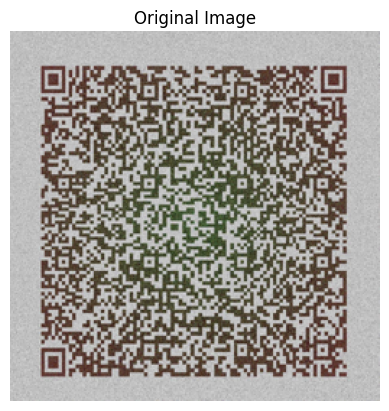

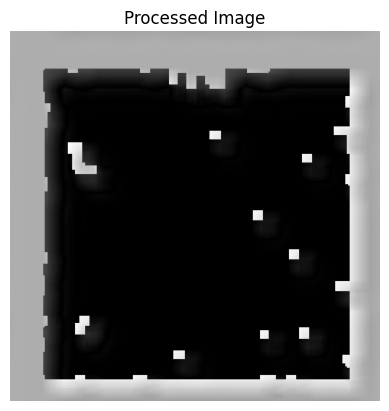

Original QR code validity: False
Processed QR code validity: False


In [ ]:
''' 
This script test the transformation pipeline for a single image.
'''
# image_name = "023127"
image_name = "023210"

image = cv2.imread(f"png/{image_name}.png")
if image is None:
    raise FileNotFoundError("Image not found. Please check the file path.")

## Show original image
show_image("Original Image", image)

## Create a pipeline with the steps
pipeline = Pipeline([
    grayscale,
    histogram_based_threshold,
    watershed,
    fourier_based_filtering, 
    blind_deconvolution(),
    # median_blur(kernel_size=5),
    # histogram_based_threshold,
    # threshold(threshold_value=230),
    # squared_opening(kernel_size=3),
    # clahe_enhancement(clip_limit=2.0, tile_grid_size=(15,15)),
    # bluring(kernel_size=3),
    # otsu_threshold,
])

# Run the pipeline
processed_image = pipeline.run(image, check_qr=True)


# Show processed image
show_image("Processed Image", processed_image)



## Check if the QR code is valid
txt_file_path = f"txt/{image_name}.txt"
original_validity = checkQr(image, txt_file_path)
processed_validity = checkQr(processed_image, txt_file_path)

print(f"Original QR code validity: {original_validity}")
print(f"Processed QR code validity: {processed_validity}")


In [12]:
'''
This script processes images in a directory, aplying a series of transformations defined in a pipeline.
'''



def checAll():
  files = os.listdir("png")
  files = [file.split(".")[0] for file in files]

  # Set pipeline
  pipeline = Pipeline([
      # threshold(128),
      # grayscale
  ])

  # Initialize counters to compare original vs transformed 
  enhanced_count = 0
  worsened_count = 0
  same_ok_count = 0
  same_false_count = 0


  for file in files:
    # Read image
    img = cv2.imread("png/" + file + ".png")
    if img is None:
      print(f"Image {file}.png not found.")
      continue

    # Read text file
    file_name = "txt/" + file + ".txt"

    # Apply pipeline
    img_transformed = pipeline.run(img)

    # Show result of pipeline 
    ok = checkQr(img, file_name)
    transformed_ok  = checkQr(img_transformed, file_name)

    if ok:
      if transformed_ok: same_ok_count += 1
      else: worsened_count += 1
    else:
      if transformed_ok: enhanced_count += 1
      else: same_false_count += 1
  

  # Print summary
  print(f"Total images: {len(files)}")
  print(f"enhanced_count: {enhanced_count}")
  print(f"worsened_count: {worsened_count}")
  print(f"same_ok_count: {same_ok_count}")
  print(f"same_false_count: {same_false_count}")


## Run the check for all images
# checAll()


In [ ]:
# Divides images in 2 folders depending on if they are recognized by the scan or not.
def divide_imgs_by_scan(folder_path, pipeline=None, pipeline_name=""):
    recognized_count = 0
    not_recognized_count = 0
    # Here we scan the images to see how much are recognized and not
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            og_img = cv2.imread(img_path)
            if og_img is None:
                print(f"Image {filename} not found.")
                continue

            txt_file_path = f"txt/{filename.split('.')[0]}.txt"

            # Apply pipeline if provided
            if pipeline:
                img = pipeline.run(og_img)
            else:
                # This is to make sure the original image is used if no pipeline is provided
                img = og_img
            
            # Check QR code validity
            ok = checkQr(img, txt_file_path)

            if ok:
                recognized_count += 1
                # print(f"Image {filename} recognized.")
            else:
                not_recognized_count += 1
                # print(f"Image {filename} not recognized.")
    
    print(f"Total images scanned: {recognized_count + not_recognized_count}")
    print(f"Recognized images with pipeline {pipeline_name}: {recognized_count}")
    print(f"Not recognized images with pipeline {pipeline_name}: {not_recognized_count}")
    choice = input("Do you want to move the images to separate folders? (y/n)")
    if choice.lower() != 'y':
        print("Exiting without moving images.")
        clear_output(wait=False)
        print(f"Total images scanned: {recognized_count + not_recognized_count}")
        print(f"Recognized images with pipeline {pipeline_name}: {recognized_count}")
        print(f"Not recognized images with pipeline {pipeline_name}: {not_recognized_count}")
        return

    # Before the for loop in divide_imgs_by_scan
    #os.makedirs(os.path.join(folder_path,pipeline_name+"_recognized"), exist_ok=True)
    #os.makedirs(os.path.join(folder_path,pipeline_name+"_not_recognized"), exist_ok=True)
    os.makedirs("processed_qrs", exist_ok=True)
    os.makedirs(os.path.join("processed_qrs", pipeline_name+"_recognized"), exist_ok=True)
    os.makedirs(os.path.join("processed_qrs", pipeline_name+"_not_recognized"), exist_ok=True)
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            og_img = cv2.imread(img_path)
            if og_img is None:
                print(f"Image {filename} not found.")
                continue
            
            txt_file_path = f"txt/{filename.split('.')[0]}.txt"
            
            # Apply pipeline if provided
            if pipeline:
                img = pipeline.run(og_img)
            else:
                # This is to make sure the original image is used if no pipeline is provided
                img = og_img

            # Check QR code validity
            ok = checkQr(img, txt_file_path)

            # Move image to appropriate folder
            target_folder = os.path.join("processed_qrs", pipeline_name + ("_recognized" if ok else "_not_recognized"))
            target_path = os.path.join(target_folder, filename)
            #target_path = os.path.join(folder_path, target_path)
            cv2.imwrite(target_path, og_img)
            # print(f"Moved {filename} to {target_folder}")

def show_random_images(folder_path, n=5):
    print(f"Showing {n} random images from {folder_path}")
    images = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    selected_images = np.random.choice(images, n, replace=False)
    
    ## Plot the images, the histogram and the fourier transform
    for img_name in selected_images:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Image {img_name} not found.")
            continue
        
        plt.figure(figsize=(10, 5))
        
        # Show image
        plt.subplot(1, 3, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Image: {img_name}")
        plt.axis('off')
        
        # Show histogram
        plt.subplot(1, 3, 2)
        plt.hist(img.ravel(), bins=256, range=[0, 256])
        plt.title('Histogram')
        plt.xlabel('Pixel value')
        plt.ylabel('Frequency')
        
        # Show Fourier Transform
        f_transform = np.fft.fft2(img)
        f_transform_shifted = np.fft.fftshift(f_transform)
        magnitude_spectrum = np.log(np.abs(f_transform_shifted) + 1)
        
        plt.subplot(1, 3, 3)
        plt.imshow(magnitude_spectrum, cmap='gray')
        plt.title('Fourier Transform Magnitude Spectrum')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

In [ ]:
divide_imgs_by_scan("png")


In [ ]:
show_random_images("processed_qrs/_recognized", n=10)
show_random_images("processed_qrs/_not_recognized", n=10)

In [45]:
pipeline = Pipeline([
    grayscale,
])
divide_imgs_by_scan("processed_qrs/_not_recognized", pipeline=pipeline, pipeline_name="grayscale")

	i=3 f=-1(000) part=1


Total images scanned: 1492
Recognized images with pipeline grayscale: 90
Not recognized images with pipeline grayscale: 1402


	i=3 f=-1(000) part=1


In [38]:
pipeline = Pipeline([
    grayscale,
    histogram_based_threshold,
    fourier_based_filtering,
])
divide_imgs_by_scan("processed_qrs/grayscale_not_recognized", pipeline=pipeline, pipeline_name="grayscale_threshold")

Peak frequency distance from center: 12.00
Peak frequency distance from center: 11.00
Peak frequency distance from center: 1.00
Peak frequency distance from center: 9.00
Peak frequency distance from center: 8.00
Peak frequency distance from center: 9.00
Peak frequency distance from center: 12.00
Peak frequency distance from center: 8.00
Peak frequency distance from center: 11.00
Peak frequency distance from center: 1.00
Peak frequency distance from center: 2.00
Peak frequency distance from center: 10.00
Peak frequency distance from center: 6.00
Peak frequency distance from center: 2.00
Peak frequency distance from center: 6.00
Peak frequency distance from center: 10.00
Peak frequency distance from center: 6.00
Peak frequency distance from center: 8.00
Peak frequency distance from center: 12.00
Peak frequency distance from center: 7.00
Peak frequency distance from center: 11.00
Peak frequency distance from center: 6.00
Peak frequency distance from center: 12.00
Peak frequency distance f

	i=10 f=-1(101) part=0


Peak frequency distance from center: 9.00
Peak frequency distance from center: 11.00
Peak frequency distance from center: 8.00
Peak frequency distance from center: 10.00
Peak frequency distance from center: 12.00
Peak frequency distance from center: 1.00
Peak frequency distance from center: 10.00
Peak frequency distance from center: 5.00
Peak frequency distance from center: 2.00
Peak frequency distance from center: 8.00
Peak frequency distance from center: 10.00
Peak frequency distance from center: 11.00
Peak frequency distance from center: 11.00
Peak frequency distance from center: 11.00
Peak frequency distance from center: 7.00
Peak frequency distance from center: 10.00
Peak frequency distance from center: 8.00
Peak frequency distance from center: 10.00
Peak frequency distance from center: 11.00
Peak frequency distance from center: 7.00
Peak frequency distance from center: 11.00
Peak frequency distance from center: 7.00
Peak frequency distance from center: 10.00
Peak frequency distan

KeyboardInterrupt: Interrupted by user

Showing 10 random images from processed_qrs/grayscale_not_recognized


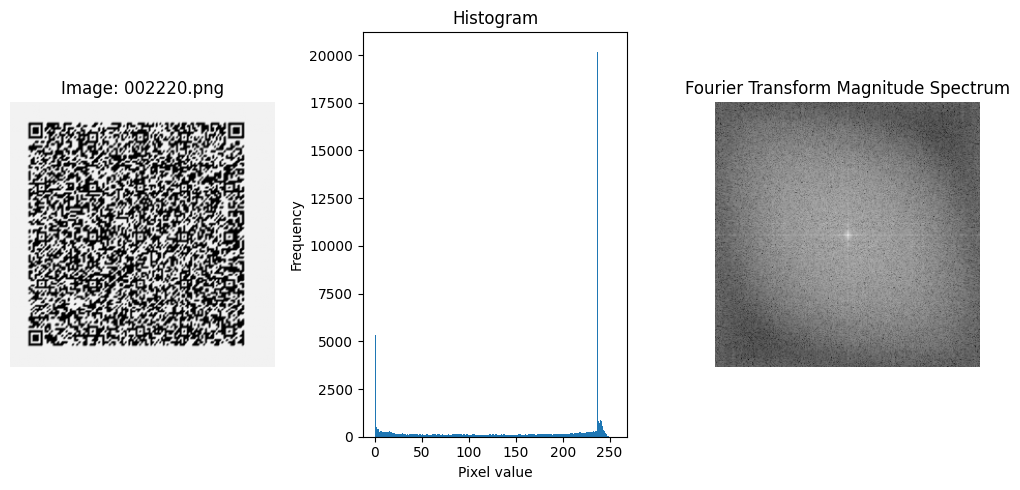

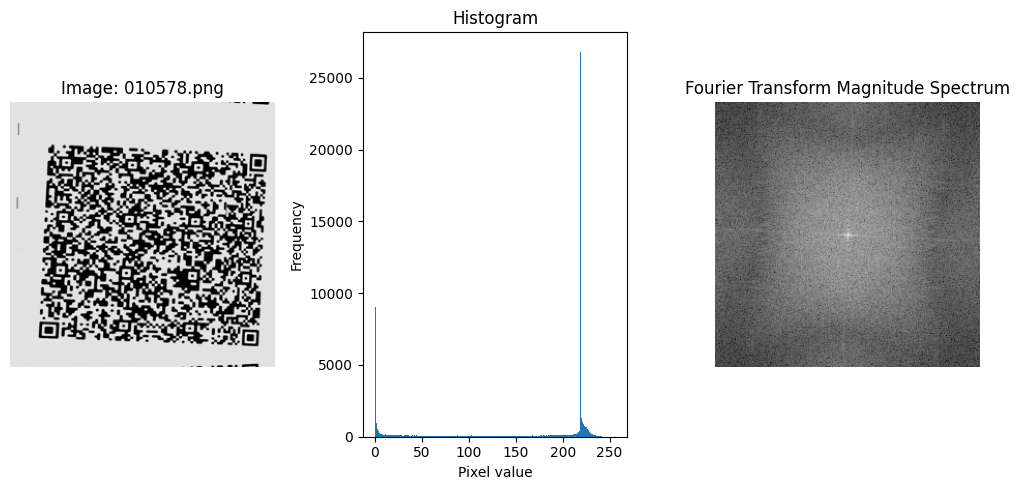

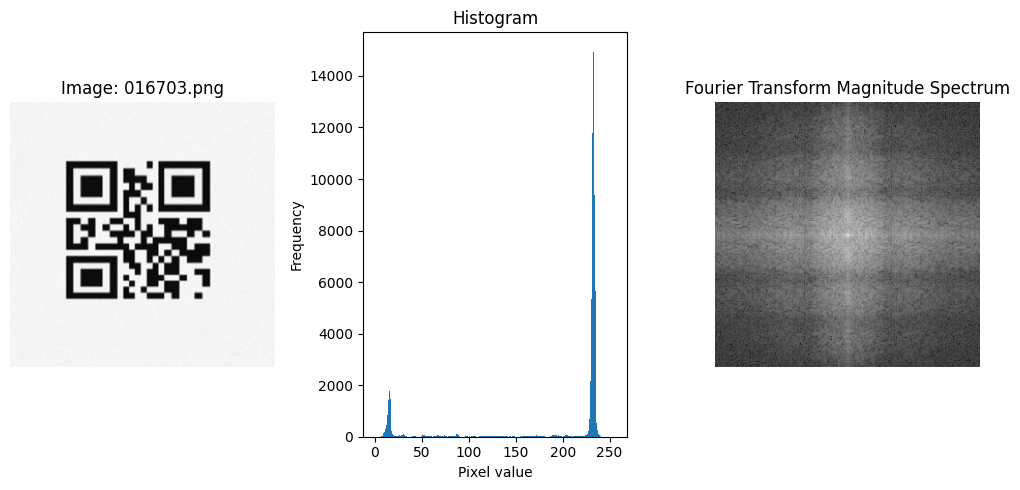

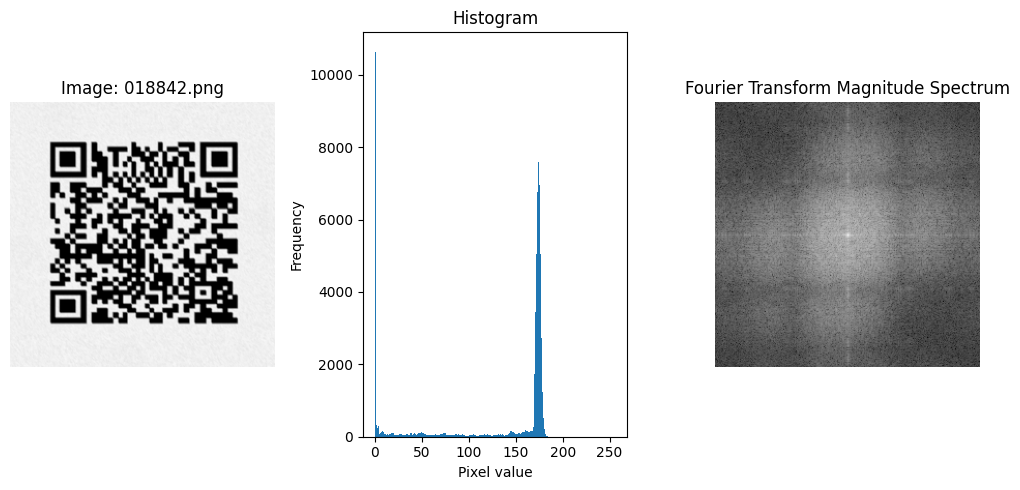

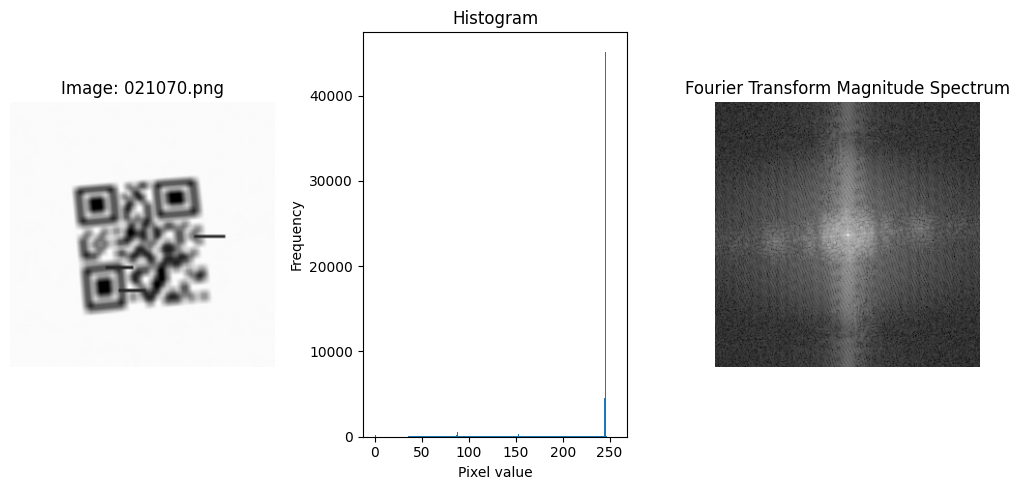

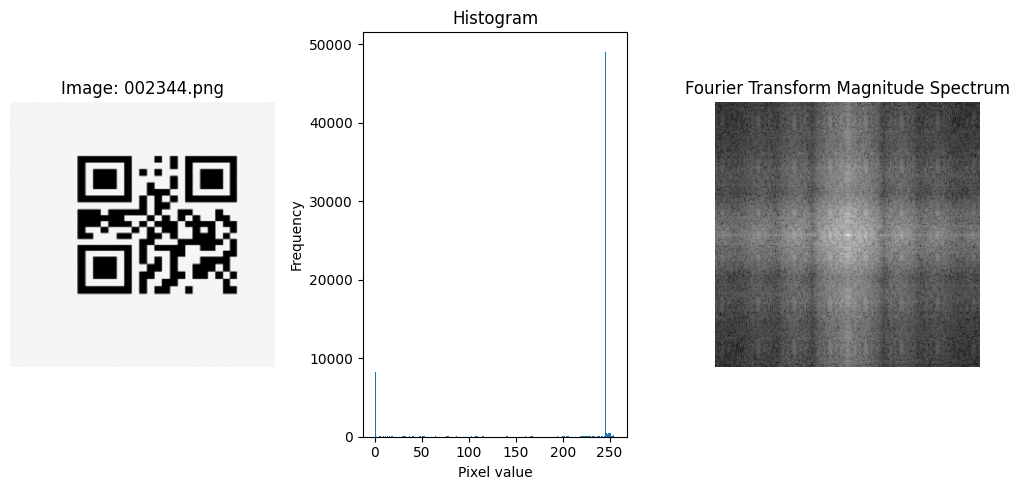

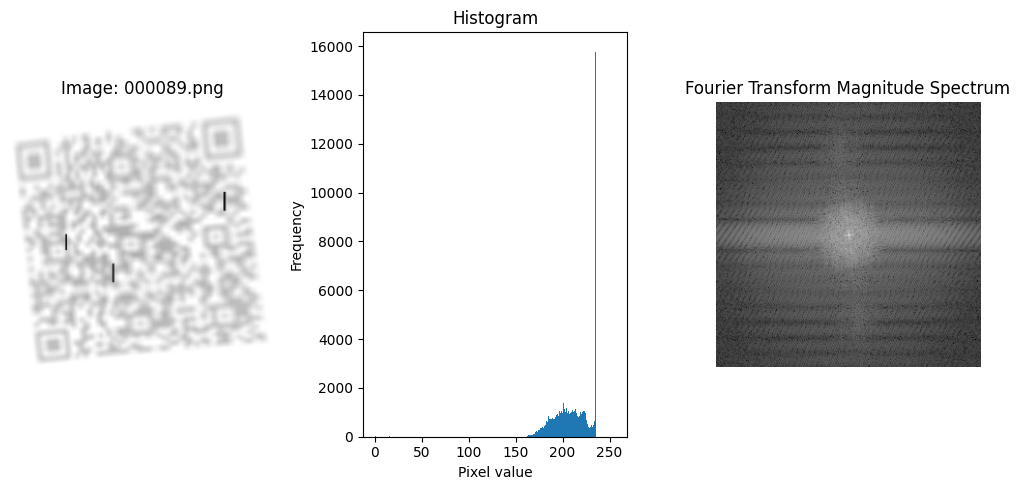

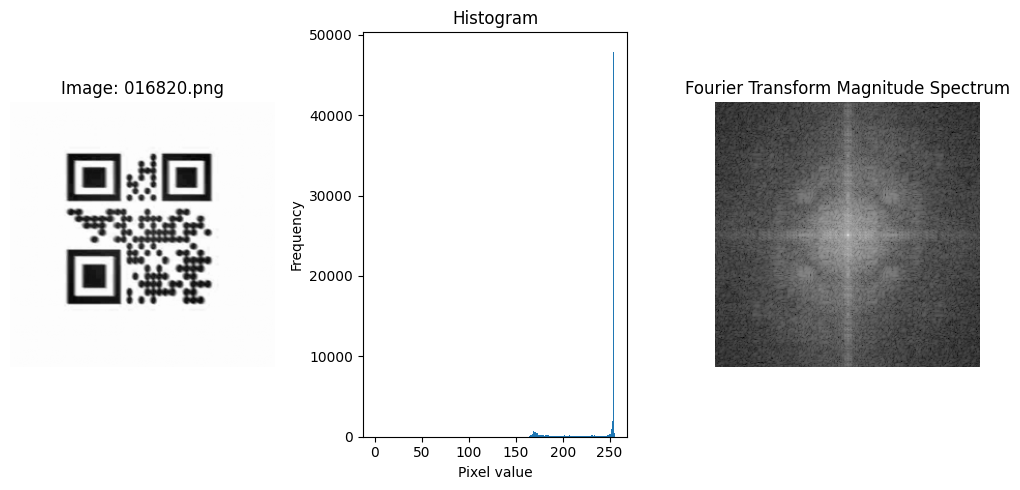

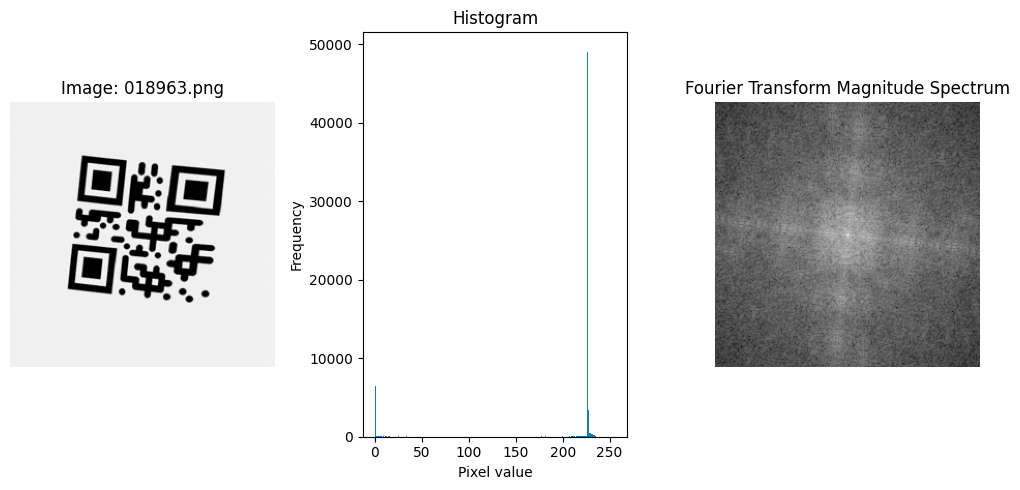

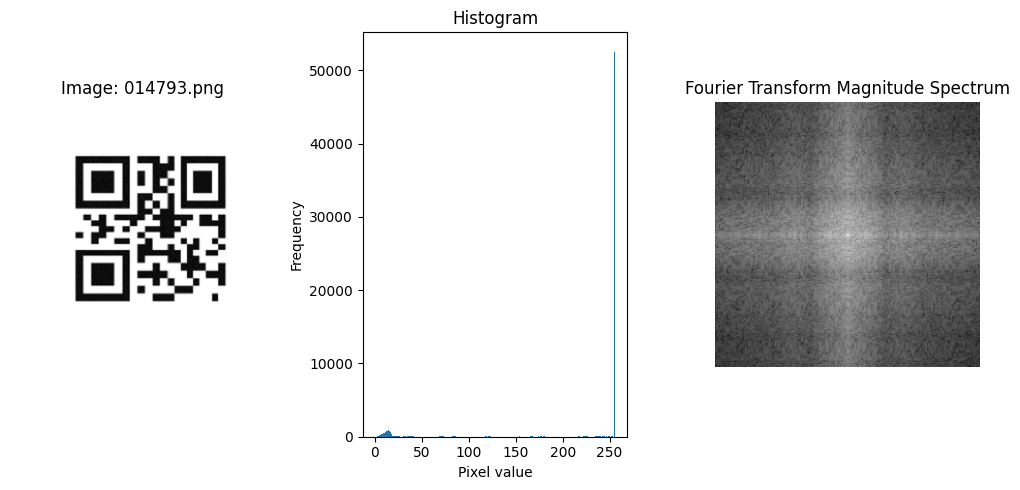

Showing 10 random images from processed_qrs/grayscale_recognized


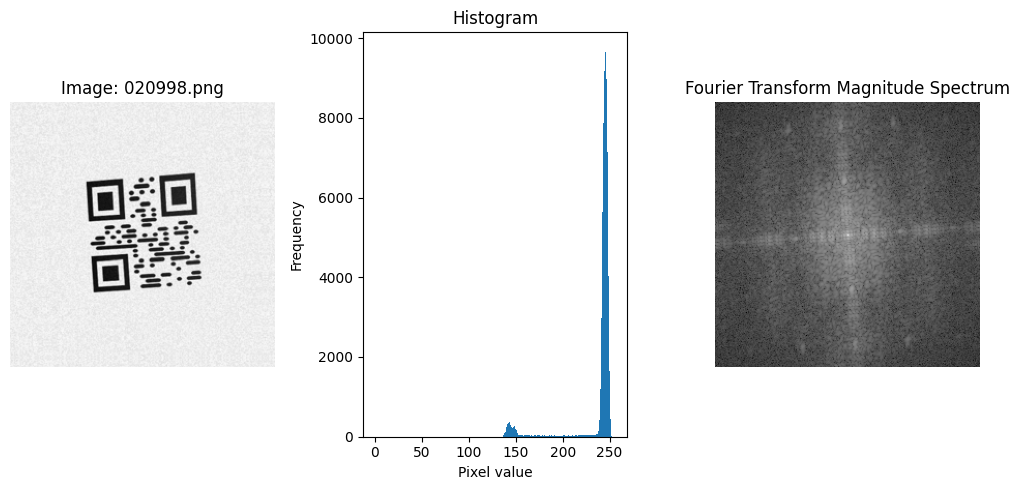

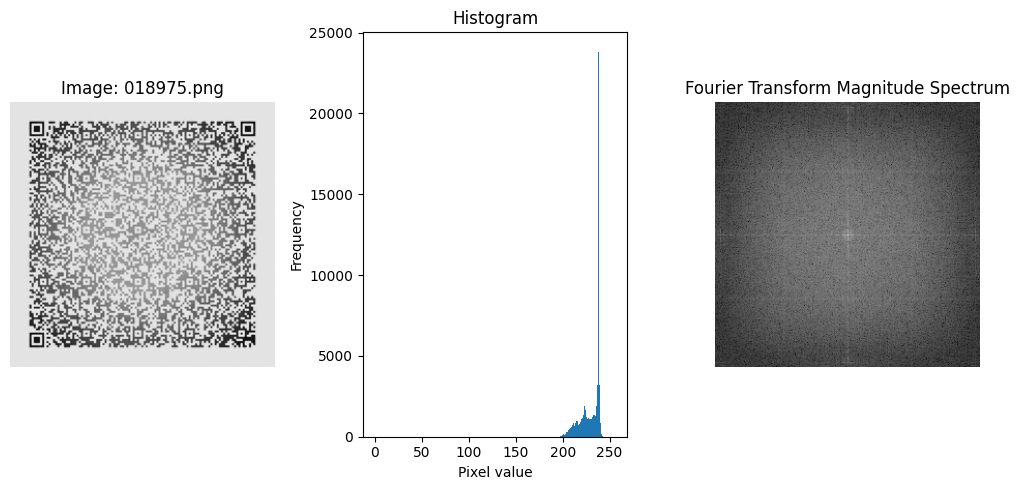

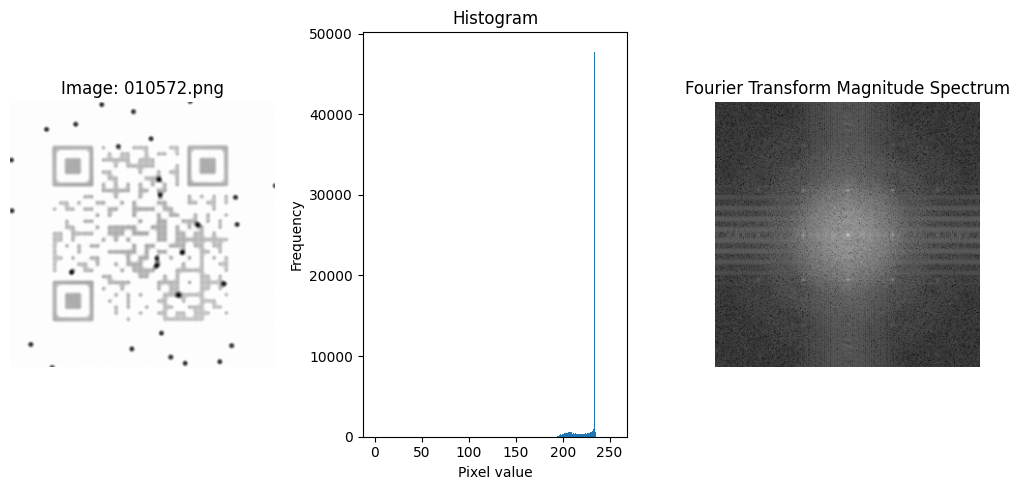

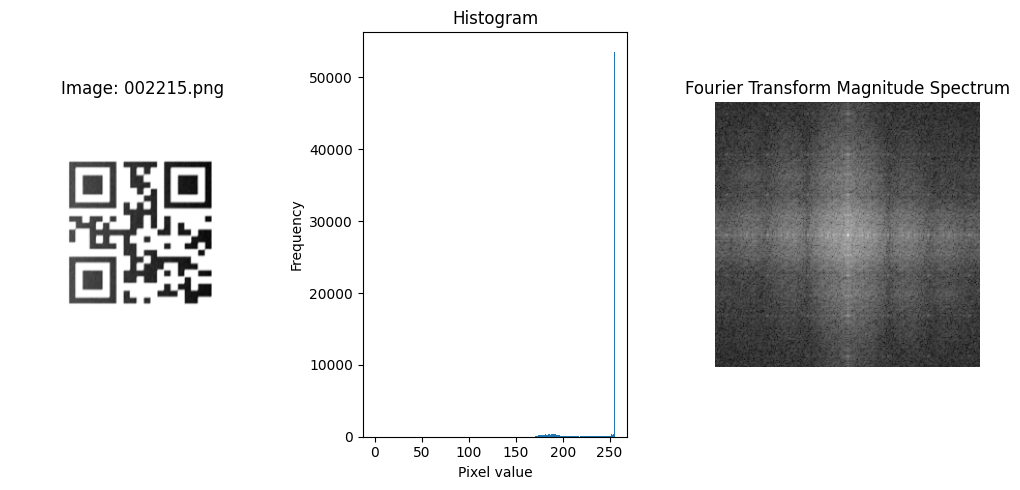

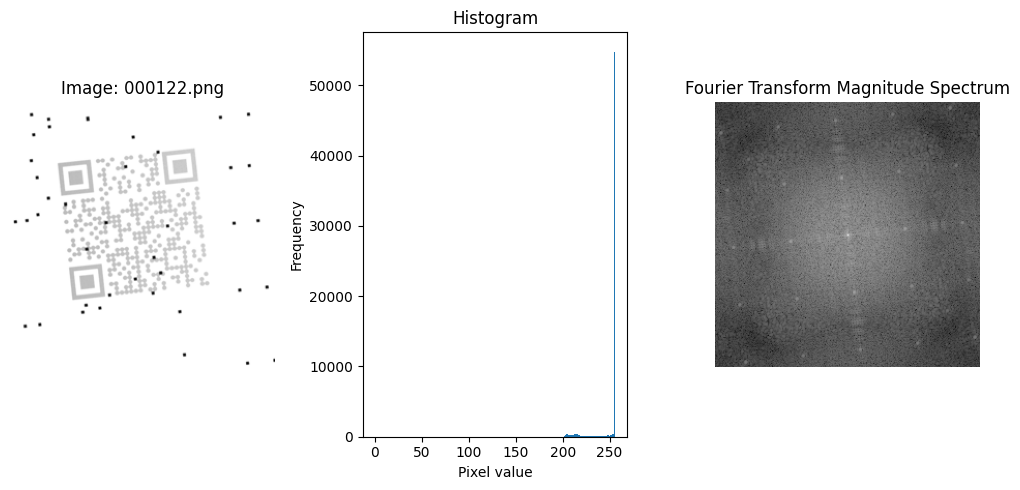

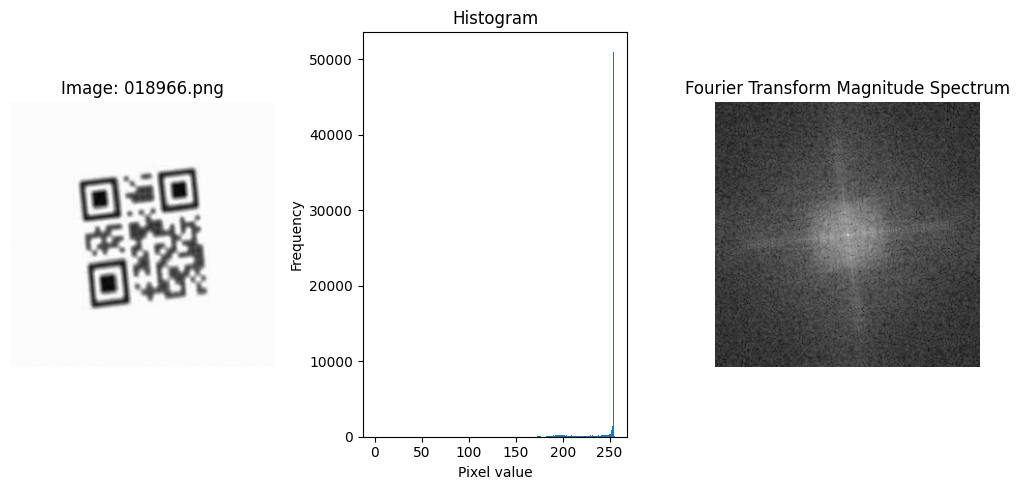

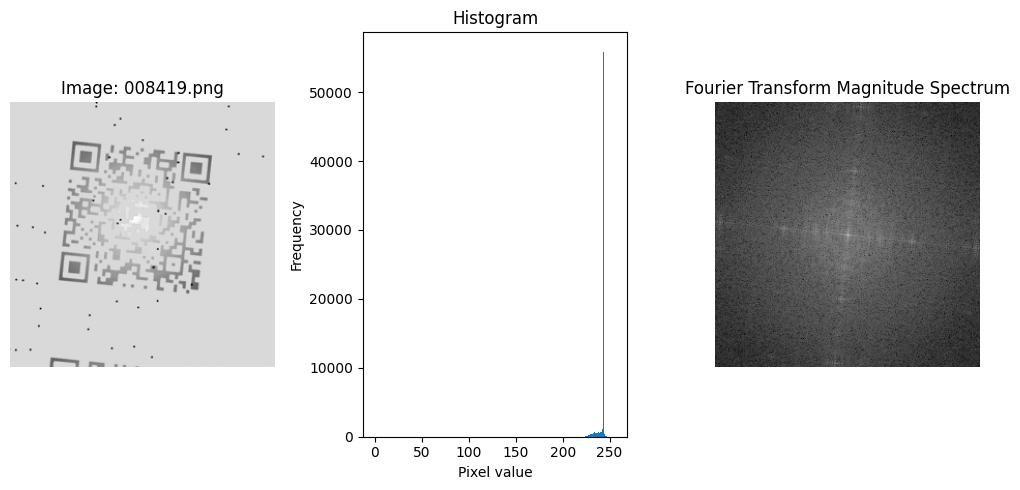

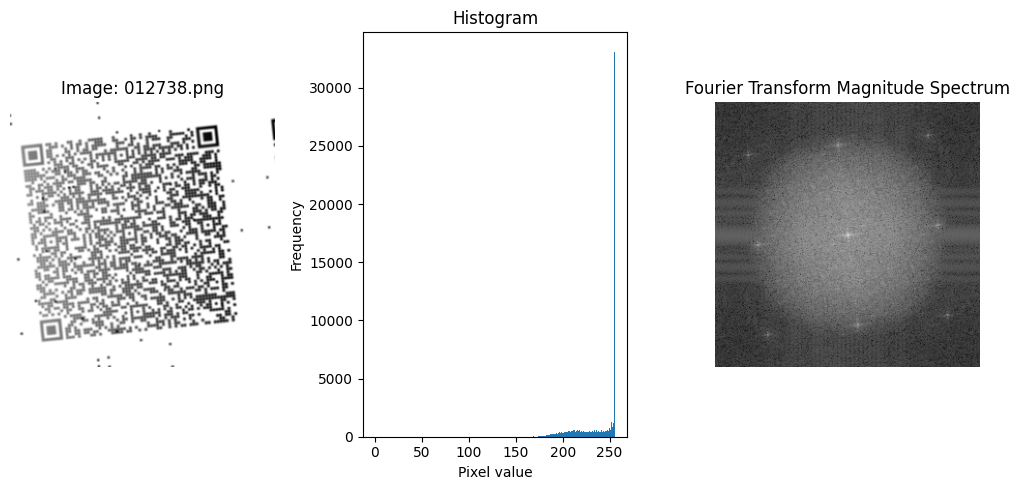

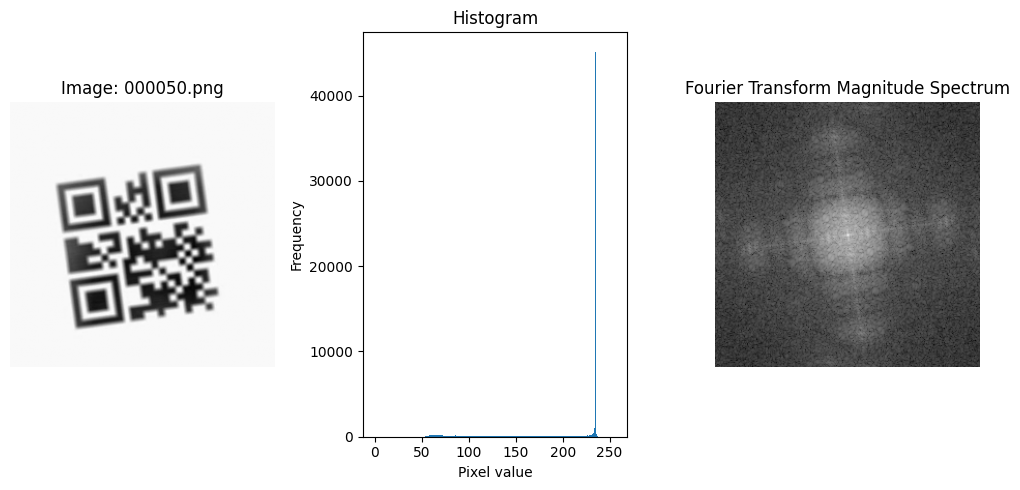

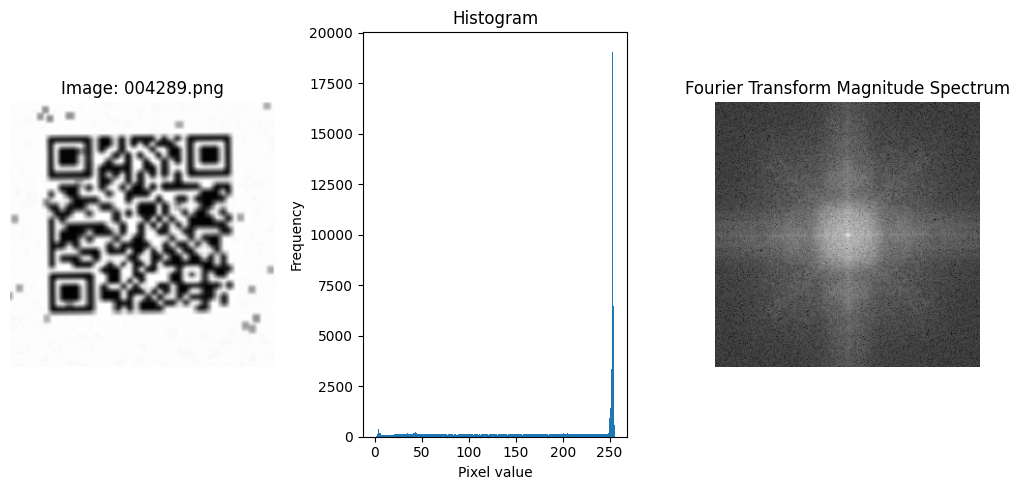

In [23]:
show_random_images("processed_qrs/grayscale_not_recognized", n=10)
show_random_images("processed_qrs/grayscale_recognized", n=10)

Vemos que las imagenes reconocidas aplicando grayscale son imagenes a colores, que es lo esperado

In [35]:
pipeline = Pipeline([
    grayscale,
])
divide_imgs_by_scan("processed_qrs/grayscale_not_recognized", pipeline=pipeline, pipeline_name="grayscale_only")

	i=3 f=-1(000) part=1


Total images scanned: 1419
Recognized images with pipeline grayscale_only: 33
Not recognized images with pipeline grayscale_only: 1386


	i=3 f=-1(000) part=1


In [ ]:
# counts how many are in a folder
def count_images_in_folder(folder_path):
    count = 0
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            count += 1
    return count


Number of images in thresholded100_recognized: 19
Number of images in thresholded110_recognized: 9
Number of images in thresholded120_recognized: 8
Number of images in thresholded130_recognized: 7
Number of images in thresholded140_recognized: 2
Number of images in thresholded150_recognized: 5
Number of images in thresholded160_recognized: 7
Number of images in thresholded170_recognized: 5
Number of images in thresholded180_recognized: 12
Number of images in thresholded190_recognized: 6
Number of images in thresholded200_recognized: 2
Number of images in thresholded210_recognized: 2
Number of images in thresholded220_recognized: 4
Number of images in thresholded230_recognized: 3
Number of images in thresholded240_recognized: 7
Number of images in thresholded250_recognized: 3
Total number of images in all thresholded folders: 101


In [ ]:
def decode_enhanced_qr(image):
    if image is None:
        raise ValueError("Input image is None")
    
    ## Check decoding without filters:
    ok, decoded = decode_qr(image)
    if ok:
        return image, decoded
    
    ## Apply grayscale filter:
    pipeline = Pipeline([
        grayscale,
        histogram_based_threshold,
        blind_deconvolution(),
        # multiple_threshold([150, 180, 200]),
        fourier_based_filtering,
    ])

    transformed_image = pipeline.run(image, check_qr=True)
    ok, decoded = decode_qr(transformed_image)
    if ok:
        return transformed_image, decoded
    

    return transformed_image, ""
        
ok_count = 0
not_count = 0    

files = os.listdir("processed_qrs/_not_recognized")
files = [file.split(".")[0] for file in files]
for file in files:
    img = cv2.imread("png/" + file + ".png")
    if img is None:
        print(f"Image {file}.png not found.")
        continue

    processed_image, decoded = decode_enhanced_qr(img)
    
    if decoded: ok_count += 1
    else: not_count += 1

print(f"Total images processed: {len(files)}, ok: {ok_count}, not ok: {not_count}")


	i=10 f=-1(101) part=0
	i=10 f=-1(101) part=0
	i=10 f=-1(101) part=0
	i=10 f=-1(101) part=0
	i=2 f=-1(000) part=1
	i=3 f=-1(000) part=1
	i=10 f=-1(000) part=0
	i=10 f=-1(000) part=0
	i=26 f=-1(000) part=0


Total images processed: 1492, ok: 119, not ok: 1373


In [52]:

pipeline = Pipeline([
    grayscale,
    histogram_based_threshold,
    blind_deconvolution(),
    # multiple_threshold([150, 180, 200]),
    # fourier_based_filtering,
    # remove_blur,
])

divide_imgs_by_scan("processed_qrs/grayscale_threshold_not_recognized", pipeline=pipeline, pipeline_name="big_pipeline")

Total images scanned: 1385
Recognized images with pipeline big_pipeline: 7
Not recognized images with pipeline big_pipeline: 1378


In [45]:
def plot_summed_histogram(folder_path, name="Summed Histogram"):
    """
    This function reads multiple grayscale images, calculates their histograms,
    sums them up, and plots the resulting histogram.
    """

    # Initialize an empty histogram
    sum_hist = np.zeros((256, 1), dtype=np.float32)

    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            og_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if og_img is None:
                print(f"Image {filename} not found.")
                continue

            hist = cv2.calcHist([og_img], [0], None, [256], [0, 256])
            sum_hist += hist

    # Plot the summed histogram
    plt.figure()
    plt.title(name)
    plt.xlabel("Pixel value")
    plt.ylabel("Total frequency")
    plt.plot(sum_hist)
    plt.xlim([0, 256])
    plt.show()


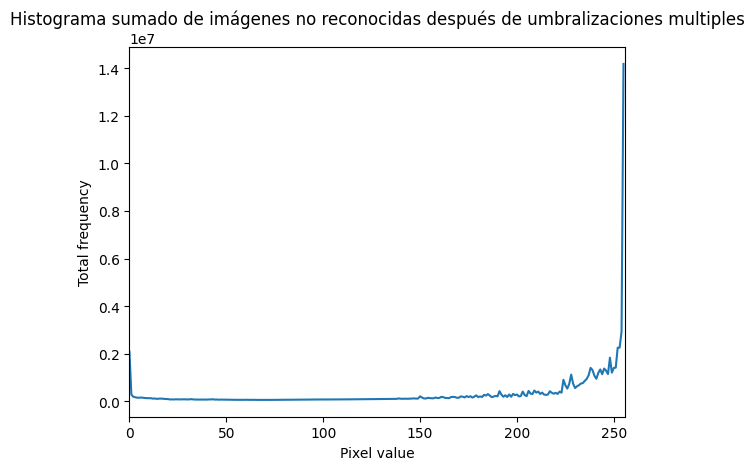

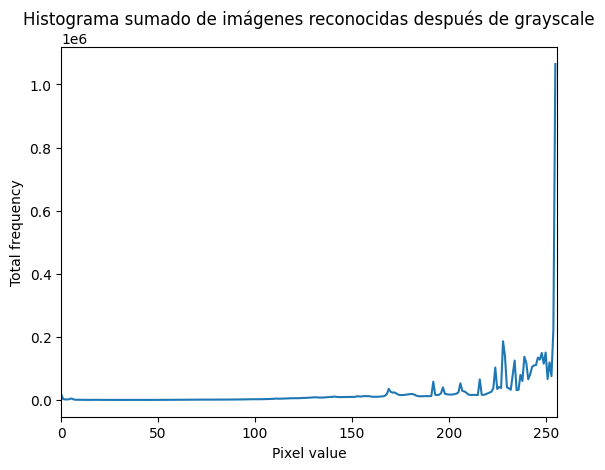

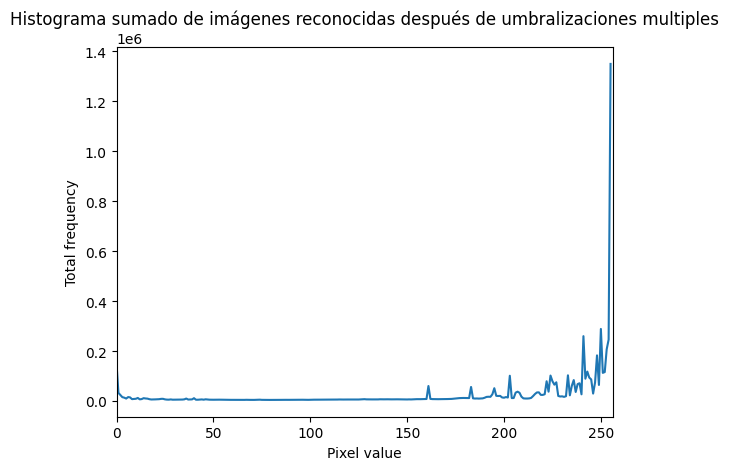

In [47]:
plot_summed_histogram("processed_qrs/grayscale_multiple_thresholds_not_recognized", name="Histograma sumado de imágenes no reconocidas después de umbralizaciones multiples")
plot_summed_histogram("processed_qrs/grayscale_recognized", name="Histograma sumado de imágenes reconocidas después de grayscale")
plot_summed_histogram("processed_qrs/grayscale_multiple_thresholds_recognized", name="Histograma sumado de imágenes reconocidas después de umbralizaciones multiples")

Los histogramas sumados no parecen tener una distinción marcada entre imagenes reconocidas y no reconocidas

In [ ]:
pipeline = Pipeline([
    grayscale,
    equalization
])
divide_imgs_by_scan("processed_qrs/grayscale_not_recognized", pipeline=pipeline, pipeline_name="grayscale_equalization")

Total images scanned: 1403
Recognized images with pipeline grayscale_equalization: 8
Not recognized images with pipeline grayscale_equalization: 1395


Equalización solo reconoce 8 imagenes después de grayscale


In [48]:
pipeline = Pipeline([
    grayscale,
    otsu_threshold
])
divide_imgs_by_scan("processed_qrs/grayscale_not_recognized", pipeline=pipeline, pipeline_name="otsu")

Total images scanned: 1403
Recognized images with pipeline otsu: 40
Not recognized images with pipeline otsu: 1363


In [40]:
pipeline = Pipeline([
    grayscale,
    otsu_threshold,
    opening(kernel=cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)))
])
divide_imgs_by_scan("processed_qrs/grayscale_not_recognized", pipeline=pipeline, pipeline_name="otsu_opening")

Total images scanned: 1403
Recognized images with pipeline otsu_opening: 34
Not recognized images with pipeline otsu_opening: 1369


In [39]:
pipeline = Pipeline([
    grayscale,
    otsu_threshold,
    closing(kernel=cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)))
])
divide_imgs_by_scan("processed_qrs/grayscale_not_recognized", pipeline=pipeline, pipeline_name="otsu_closing")

Total images scanned: 1403
Recognized images with pipeline otsu_closing: 38
Not recognized images with pipeline otsu_closing: 1365


In [75]:
pipeline = Pipeline([
    grayscale,
    subtract(constant=100)
])
divide_imgs_by_scan("processed_qrs/grayscale_not_recognized", pipeline=pipeline, pipeline_name="subtract")

Total images scanned: 1403
Recognized images with pipeline subtract: 28
Not recognized images with pipeline subtract: 1375


In [85]:
pipeline = Pipeline([
    grayscale,
    divide(constant=1.5)
])
divide_imgs_by_scan("processed_qrs/grayscale_not_recognized", pipeline=pipeline, pipeline_name="divide")

Total images scanned: 1403
Recognized images with pipeline divide: 21
Not recognized images with pipeline divide: 1382
